**Predict student performance from game play using GLM (LOGISTIC REGRESSION) and PYMC (SAMPLING WITH MARKOV CHAINS) models**

This is a dataset from the current kagle competition.
https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview

 The task is to predict student performance during game learning. It is necessary to predict the answer to 18 questions related to user interaction with the interface. The game of choice was Joe Wilder and the Capitol Case, targeted at grades 3-5 on the topic of history.

The target variable is a binary value, whether the given user will correctly answer the given question. 

The train_labels.csv file contains the session_id and correct columns, where the first value is the user's session ID, and the second value is the user's correct or incorrect answer.



Features are the various events associated with the user tapping the screen, here are its most important characteristics:

level - at what level of the game the event occurred

hover_duration - how long (in milliseconds) the hover took place

text - the text that the player sees during this event

fullscreen - whether the player is in full screen mode

music - turn on or off the music in the game

level_group - to which group of levels and to which group of questions this one belongs

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
def get_group_level(q):
    qno = int(q[1:])
    if qno < 4:
        return '0-4'
    elif qno < 14:
        return '5-12'
    return '13-22'

train label

In [ ]:
train_label = pd.read_csv("train_labels.csv")
train_label['q'] = train_label['session_id'].apply(lambda s: s.split("_")[-1])
train_label['qindex'] = train_label['q'].apply(lambda q: int(q[1:]))
train_label['session_id'] = train_label['session_id'].apply(lambda s: int(s.split("_")[0]))
train_label['level_group'] = train_label.q.apply(get_group_level)

train_label.head()

,session_id,correct,q,qindex,level_group
0,20090312431273200,1,q1,1,0-4
1,20090312433251036,0,q1,1,0-4
2,20090312455206810,1,q1,1,0-4
3,20090313091715820,0,q1,1,0-4
4,20090313571836404,1,q1,1,0-4


In [ ]:
train_label['q'].unique()

array(['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11',
       'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18'], dtype=object)

train dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
source = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv" ,
                       usecols=['session_id', 
                                'index', 'elapsed_time',
                                'event_name',
                                'level', 'level_group'],
                       dtype={'index': np.int16, 
                              'level': np.int8,
                              'event_name':'category'})

In [ ]:
train_df = source
train_df['elapsed_time'] = train_df['elapsed_time']/1000/60
train_df.head()

,session_id,index,elapsed_time,event_name,level,level_group
0,20090312431273200,0,0.000000,cutscene_click,0,0-4
1,20090312431273200,1,0.022050,person_click,0,0-4
2,20090312431273200,2,0.013850,person_click,0,0-4
3,20090312431273200,3,0.019117,person_click,0,0-4
4,20090312431273200,4,0.031050,person_click,0,0-4


### 1. Data analysis, merge tables and generating features

In [ ]:
def get_time_spent_stats(df):
    df['index2'] = df['index']+1
    df = df.merge(df[['session_id', 'level_group', 'index2', 'elapsed_time']],
                  left_on = ['session_id', 'level_group', 'index'],
                  right_on = ['session_id', 'level_group', 'index2'],
                  suffixes = ("_curr", "_prev"))

    df['time_spent'] = df['elapsed_time_curr'] - df['elapsed_time_prev']
    df.drop(columns=['elapsed_time_curr', 'elapsed_time_prev', 'index2_curr', 'index2_prev'], inplace=True)

    df['time_spent'] = np.abs(df['time_spent'])
    df['time_spent'] = df['time_spent'].clip(0, 10)
    group_stat = df.groupby(['session_id', 'level_group'])[['time_spent']].sum().reset_index()
    gp_event_stat = df.groupby(['session_id', 'level_group', 'event_name'])[['time_spent']].sum().reset_index()
    level_stat = df.groupby(['session_id', 'level_group', 'level'])[['time_spent']].sum().reset_index()
    
    return {
        'group_stat':group_stat,
        'gp_event_stat': gp_event_stat,
        'level_stat':level_stat
    }

In [ ]:
stat_map = get_time_spent_stats(train_df)

In [ ]:
stat_map['group_stat'].head()

,session_id,level_group,time_spent
0,20090312431273200,0-4,3.269800
1,20090312431273200,13-22,7.305317
2,20090312431273200,5-12,4.669267
3,20090312433251036,0-4,3.901600
4,20090312433251036,13-22,44.260017


In [ ]:
stat_map['gp_event_stat'].head()

,session_id,level_group,event_name,time_spent
0,20090312431273200,0-4,checkpoint,0.513950
1,20090312431273200,0-4,cutscene_click,0.453000
2,20090312431273200,0-4,map_click,0.022500
3,20090312431273200,0-4,map_hover,0.051400
4,20090312431273200,0-4,navigate_click,1.222083


In [ ]:
stat_map['level_stat'].head()

,session_id,level_group,level,time_spent
0,20090312431273200,0-4,0,0.445833
1,20090312431273200,0-4,1,0.667283
2,20090312431273200,0-4,2,0.587567
3,20090312431273200,0-4,3,0.917350
4,20090312431273200,0-4,4,0.651767


In [ ]:
def get_column_map(stat_map):
    cols_map = {
        '0-4':['0-4'],'5-12': ['5-12'],'13-22': ['13-22']
    }

    level_stat = stat_map['level_stat']
    gp_event_stat = stat_map['gp_event_stat']
    group_stat = stat_map['group_stat']
    
    for index, row in level_stat[['level_group', 'level']].drop_duplicates().iterrows():
        lg = row.level_group; level=row.level
        cols_map[lg].append(level)

    for index, row in gp_event_stat[['level_group', 'event_name']].drop_duplicates().iterrows():
        lg = row.level_group; event_name=row.event_name
        cols_map[lg].append(event_name)
    
    return cols_map

In [ ]:
cols_map = get_column_map(stat_map)
cols_map['0-4']

['0-4',
 0,
 1,
 2,
 3,
 4,
 'checkpoint',
 'cutscene_click',
 'map_click',
 'map_hover',
 'navigate_click',
 'notebook_click',
 'notification_click',
 'object_click',
 'object_hover',
 'observation_click',
 'person_click']

In [ ]:
def get_timestamp_quantile_stat(stat_map):
    level_stat = stat_map['level_stat']
    group_stat = stat_map['group_stat']
    gp_event_stat = stat_map['gp_event_stat']
    
    qmap = {
        '0-4': {},
        '5-12': {},
        '13-22': {}
    }
    for lg in ['0-4', '5-12', '13-22']:
        df = level_stat[level_stat.level_group == lg]
        for colname in df.level.unique():
            s = df[df.level == colname]['time_spent'].values
            qmap[lg][colname] = {}
            qmap[lg][colname]['q95'] = np.quantile(s, 0.95)
            qmap[lg][colname]['q99'] = np.quantile(s, 0.99)
        
        
        df = group_stat[group_stat.level_group == lg]
        for colname in df.level_group.unique():
            s = df[df.level_group == colname]['time_spent'].values
            qmap[lg][colname] = {}
            qmap[lg][colname]['q95'] = np.quantile(s, 0.95)
            qmap[lg][colname]['q99'] = np.quantile(s, 0.99)
        
        df = gp_event_stat[gp_event_stat.level_group == lg]
        for colname in df.event_name.unique():
            s = df[df.event_name == colname]['time_spent'].values
            qmap[lg][colname] = {}
            qmap[lg][colname]['q95'] = np.quantile(s, 0.95)
            qmap[lg][colname]['q99'] = np.quantile(s, 0.99)
    return qmap

In [ ]:
qmap = get_timestamp_quantile_stat(stat_map)
qmap['0-4']

{0: {'q95': 1.4713716666666672, 'q99': 3.354666833333294},
 1: {'q95': 1.8920616666666679, 'q99': 5.080590666666662},
 2: {'q95': 2.317227500000001, 'q99': 6.794599333333331},
 3: {'q95': 2.783757500000002, 'q99': 8.681608666666653},
 4: {'q95': 2.175647500000001, 'q99': 5.81373749999997},
 '0-4': {'q95': 11.23675166666669, 'q99': 18.53872883333333},
 'checkpoint': {'q95': 1.6923933333333336, 'q99': 3.7538111666666643},
 'cutscene_click': {'q95': 1.7392233333333342, 'q99': 4.3194001666666635},
 'map_click': {'q95': 0.10832999999999929, 'q99': 0.21775033333334295},
 'map_hover': {'q95': 0.08464666666666068, 'q99': 0.17391033333333325},
 'navigate_click': {'q95': 3.228229166666668, 'q99': 11.125189000000008},
 'notebook_click': {'q95': 0.6098916666666659, 'q99': 1.1296744999999988},
 'notification_click': {'q95': 0.6076116666666672, 'q99': 1.2557601666666658},
 'object_click': {'q95': 1.2054566666666706, 'q99': 2.8832794999999876},
 'object_hover': {'q95': 0.19769333333333275, 'q99': 0.3

In [ ]:
def preprocess(stat_map, qmap):
    group_stat = stat_map['group_stat'];
    gp_event_stat = stat_map['gp_event_stat']
    level_stat = stat_map['level_stat']
    
    def get_processed_time_spent(time_spent, lg, colname):
        q95 = qmap[lg][colname]['q95']
        q99 = qmap[lg][colname]['q99']
        
        time_spent = np.clip(time_spent, 0, q99)
        time_spent = time_spent/q95
        return np.log(1+time_spent)
    
    def process_gp_events(row):
        lg = row.level_group;
        event_name = row.event_name
        time_spent = row.time_spent
        return get_processed_time_spent(time_spent, lg, event_name)
    
    
    def process_level(row):
        lg = row.level_group;
        level=row.level
        time_spent = row.time_spent
        return get_processed_time_spent(time_spent, lg, level)
    
    def process_group(row):
        lg = row.level_group;
        time_spent = row.time_spent
        return get_processed_time_spent(time_spent, lg, lg)
    
    group_stat['time_spent'] = group_stat.apply(process_group, axis=1)
    gp_event_stat['time_spent'] = gp_event_stat.apply(process_gp_events, axis=1)
    level_stat['time_spent'] = level_stat.apply(process_level, axis=1)
    
    return {
        'gp_event_stat': gp_event_stat,
        'level_stat': level_stat,
        'group_stat': group_stat
    }

In [ ]:
stat_map = preprocess(stat_map, qmap)

In [ ]:
stat_map['group_stat'].head()

,session_id,level_group,time_spent
0,20090312431273200,0-4,0.255411
1,20090312431273200,13-22,0.203437
2,20090312431273200,5-12,0.196145
3,20090312433251036,0-4,0.298042
4,20090312433251036,13-22,0.861570


In [ ]:
stat_map['level_stat'].head()

,session_id,level_group,level,time_spent
0,20090312431273200,0-4,0,0.264673
1,20090312431273200,0-4,1,0.302084
2,20090312431273200,0-4,2,0.225991
3,20090312431273200,0-4,3,0.284830
4,20090312431273200,0-4,4,0.262036


In [ ]:
stat_map['gp_event_stat'].head()

,session_id,level_group,event_name,time_spent
0,20090312431273200,0-4,checkpoint,0.265193
1,20090312431273200,0-4,cutscene_click,0.231478
2,20090312431273200,0-4,map_click,0.188717
3,20090312431273200,0-4,map_hover,0.474512
4,20090312431273200,0-4,navigate_click,0.321041


In [ ]:
def get_features(stat_map, colmap):
    level_stat = stat_map['level_stat']
    gp_event_stat = stat_map['gp_event_stat']
    group_stat = stat_map['group_stat']
    
    feat_map = {}
    for lg in ['0-4', '5-12', '13-22']:
        df1 = level_stat[level_stat.level_group == lg]
        df2 = group_stat[group_stat.level_group == lg]
        df3 = gp_event_stat[gp_event_stat.level_group == lg]

        df1 = pd.pivot_table(data=df1, index='session_id', columns='level', values='time_spent')
        df2 = pd.pivot_table(data=df2, index='session_id', columns='level_group', values='time_spent')
        df3 = pd.pivot_table(data=df3, index='session_id', columns='event_name', values='time_spent')

        df1.columns = list(df1.columns)
        df2.columns = list(df2.columns)
        df3.columns = list(df3.columns)

        df = df1.merge(df2, on='session_id').merge(df3, on='session_id')
        df.fillna(0.0, inplace=True)
        
        all_columns = list(colmap[lg])
        missed_columns = list(set(all_columns).difference(df.columns))
        
        for colname in missed_columns:
            df[colname] = 0.0
        
        df.columns = all_columns
        feat_map[lg] = df
    return feat_map

In [ ]:
feat_map = get_features(stat_map, cols_map)
feat_map['0-4']

,0-4,0,1,2,3,4,checkpoint,cutscene_click,map_click,map_hover,navigate_click,notebook_click,notification_click,object_click,object_hover,observation_click,person_click
session_id,,,,,,,,,,,,,,,,,
20090312431273200,0.264673,0.302084,0.225991,0.284830,0.262036,0.255411,0.265193,0.231478,0.188717,0.474512,0.321041,0.000000,0.336302,0.241850,0.062499,0.302153,0.249666
20090312433251036,0.138832,0.309326,0.506531,0.215034,0.313298,0.298042,0.313645,0.420778,0.341961,0.358103,0.306889,0.080485,0.200345,0.156913,0.352503,0.297214,0.389369
20090312455206810,0.123463,1.139189,0.221258,0.202972,0.281209,0.434753,0.249256,0.259537,0.250346,0.348145,0.867713,0.000000,0.401611,0.115040,0.046774,0.000000,0.110815
20090313091715820,0.188837,0.271107,0.178618,0.281357,0.392691,0.257429,0.386089,0.207199,0.289573,0.387265,0.301000,0.066444,0.262069,0.210232,0.427819,0.218015,0.170892
20090313571836404,0.350549,0.234259,0.294598,0.209446,0.280804,0.255078,0.273341,0.302107,0.354559,0.079091,0.244541,0.193222,0.308766,0.246140,0.396670,0.000000,0.278126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,0.647744,0.750524,0.629772,0.565146,0.565290,0.600938,0.558897,0.654354,0.228428,0.516613,0.688034,0.129779,0.784634,0.523624,0.770871,0.698994,0.607123
22100215460321130,0.506044,0.420954,0.499039,0.312718,0.516331,0.425041,0.520886,0.472749,0.359726,0.435413,0.397129,0.503045,0.482999,0.317631,0.484288,0.163259,0.448701
22100217104993650,0.533565,0.380083,0.298816,0.761603,0.356379,0.474825,0.335019,0.292325,0.813474,0.000000,0.512249,1.008230,0.420937,0.368294,0.558256,0.464755,0.634180


### 2. Linear Model

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss

In [ ]:
model_map = {
    '0-4': [],
    '5-12':[],
    '13-22': []
}

In [ ]:
for lg in ['0-4', '5-12', '13-22']:
    feat_df = feat_map[lg]
    feat_columns = list(feat_df.columns)

    #labels
    lg_label_df = train_label[train_label.level_group == lg]
    lg_label_df = lg_label_df.sort_values('qindex')
    num_quenstions = lg_label_df.qindex.nunique()
    lg_label_df = lg_label_df.groupby(['session_id'])[['correct']].agg(list)
    
    #lg dataset
    lg_data = feat_df.merge(lg_label_df, on = 'session_id')

    X = lg_data[feat_columns].values
    y = np.stack(lg_data['correct'].values)

    clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)
    model_map[lg].append(clf)

    ypred = clf.predict(X)
    print("level group --> ", lg)
    print("Train fscore --> ", f1_score(y.flatten(), ypred.flatten()))
    print("Train accuracy_score --> ", accuracy_score(y.flatten(), ypred.flatten()))
    labels = np.array([0, 1])
    print("Train hinge_loss --> ", hinge_loss(y.flatten(), ypred.flatten(), labels = labels))
    print()

level group -->  0-4
Train fscore -->  0.9370965411841635
Train accuracy_score -->  0.8829612653142065
Train hinge_loss -->  0.2369351781116487

level group -->  5-12
Train fscore -->  0.803152546130197
Train accuracy_score -->  0.7135811900517783
Train hinge_loss -->  0.6365079365079365

level group -->  13-22
Train fscore -->  0.8367032349996557
Train accuracy_score -->  0.7383329089211442
Train hinge_loss -->  0.5492657669128257



In [ ]:
X.shape

(23562, 22)

In [ ]:
y.shape

(23562, 5)

Validation gives the similar loss

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=1, random_state=0, shuffle=True)

In [ ]:
for lg in ['0-4', '5-12', '13-22']:
    feat_df = feat_map[lg]
    feat_columns = list(feat_df.columns)
    
    #labels
    lg_label_df = train_label[train_label.level_group == lg]
    lg_label_df = lg_label_df.sort_values('qindex')
    num_quenstions = lg_label_df.qindex.nunique()
    lg_label_df = lg_label_df.groupby(['session_id'])[['correct']].agg(list)
    
    #lg dataset
    lg_data = feat_df.merge(lg_label_df, on = 'session_id')
    
    session_ids = lg_label_df.index.unique()
    for foldnum, (train_index, val_index) in enumerate(kf.split(session_ids)):
        train_sess = session_ids[train_index]
        val_sess = session_ids[val_index]
    
        lg_train_data = lg_data.loc[train_sess, :]
        lg_val_data = lg_data.loc[val_sess, :]

        X = lg_train_data[feat_columns].values
        y = np.stack(lg_train_data['correct'].values)

        clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)
        model_map[lg].append(clf)

        ypred = clf.predict(X)
        print("level group --> ", lg)
        print("foldnum : ", foldnum)
        print("Train fscore --> ", f1_score(y.flatten(), ypred.flatten()))


        Xtest = lg_val_data[feat_columns].values
        ytest = np.stack(lg_val_data['correct'].values)
        ypred_test = clf.predict(Xtest)
        print("Test fscore --> ", f1_score(ytest.flatten(), ypred_test.flatten()))
        print()

### 2. MCMC approach
Model:

$$
t_i | x_i, \mathbf w \sim \mathrm{Be}(\theta(\mathbf x_i))
\\
\theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x)
\\
\mathbf w_j \sim  \mathcal N(0, S_j)
$$

In [ ]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
# normalize data and append ones to make sampler's life easy
x_means = X.mean(axis=0)
x_scales = X.std(axis=0)
zX = ((X-x_means)/x_scales)
zX = np.hstack([np.ones(shape=(zX.shape[0], 1)), zX])
zX.shape

x_means= [0.39884796 0.33241315 0.27177791 0.42345317 0.29706129 0.30067661
 0.31922184 0.29980256 0.26678788 0.27409713 0.3722148  0.54854804
 0.39022054 0.29296922 0.25295557 0.31117991 0.21952112 0.34535693
 0.35188733 0.33329393 0.40014925 0.34768689]
x_scales= [0.19066368 0.20342074 0.21655869 0.19081069 0.21636274 0.16613072
 0.21985321 0.22395362 0.19644359 0.2259079  0.15249741 0.21079275
 0.19220945 0.20030354 0.25198675 0.16863674 0.27808192 0.19526833
 0.19076801 0.2056753  0.15850201 0.17329332]


(23562, 23)

In [ ]:
zX[:10]

array([[ 1.        , -0.47538751, -0.80093738, -0.5075537 , -0.99803125,
        -0.49854761, -0.76349872, -0.87266416, -0.03052087, -0.85160399,
        -0.63529848, -1.10675524,  0.52708678, -0.77999926, -0.73854049,
        -0.61982939, -0.88658458, -0.78941172, -0.826749  , -0.91786008,
        -0.67899172, -1.32844535, -0.51198143],
       [ 1.        , -0.74685364, -0.02666346, -0.3687719 ,  0.53845805,
         5.01638048, -0.63397748,  1.175662  ,  1.27194515,  1.77433852,
         2.50156304,  3.20893799,  0.54333336,  0.04094865,  4.69704564,
         5.59850965,  2.98891475,  2.35668027,  0.89793639,  1.52866832,
         2.67510903,  0.63005001,  0.5733945 ],
       [ 1.        , -0.78846357, -0.87254419, -0.40934931, -1.04626435,
        -0.26891377, -0.9576905 , -0.84416494, -0.42282749, -0.4353028 ,
        -0.22433272, -1.07872527,  0.51311672, -1.19673965, -0.05716634,
        -0.26464613, -0.74808311,  0.68834361, -0.75656793, -1.37504487,
        -0.18657277, -0.6114

In [ ]:
y

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1],
       ...,
       [1, 0, 0, 1, 1],
       [1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1]])

In [ ]:
Y = np.stack((y), axis=-1)
t = Y[0]

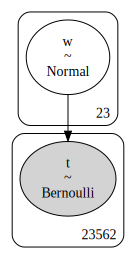

In [ ]:
with pm.Model() as model:
    mu = 0 # mean = 0 for all predictors
    sigma = np.concatenate((np.array([10]), np.repeat(2, 22)), axis = None)  # sd=10 for w0 and sd=2 for predictors
    w = pm.Normal('w', mu=mu, sigma=sigma, shape=(23)) 
    # invlogit func is the same as logistic func:
    theta = pm.invlogit(pm.math.dot(w, zX.T))
    outputs = pm.Bernoulli('t', theta, observed=t)
    
pm.model_to_graphviz(model)

In [ ]:
draws = 2000
tune = 1000
chains = 4
cores = 2

In [ ]:
with model:
    trace = pm.sample(draws=draws, tune=tune, chains=chains, cores=cores,
                      return_inferencedata=True)

In [ ]:
trace.posterior['w'].shape

(4, 2000, 23)

array([[<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

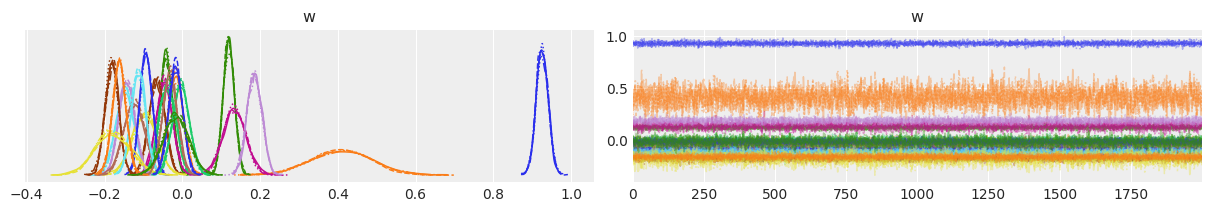

In [ ]:
az.plot_trace(trace)

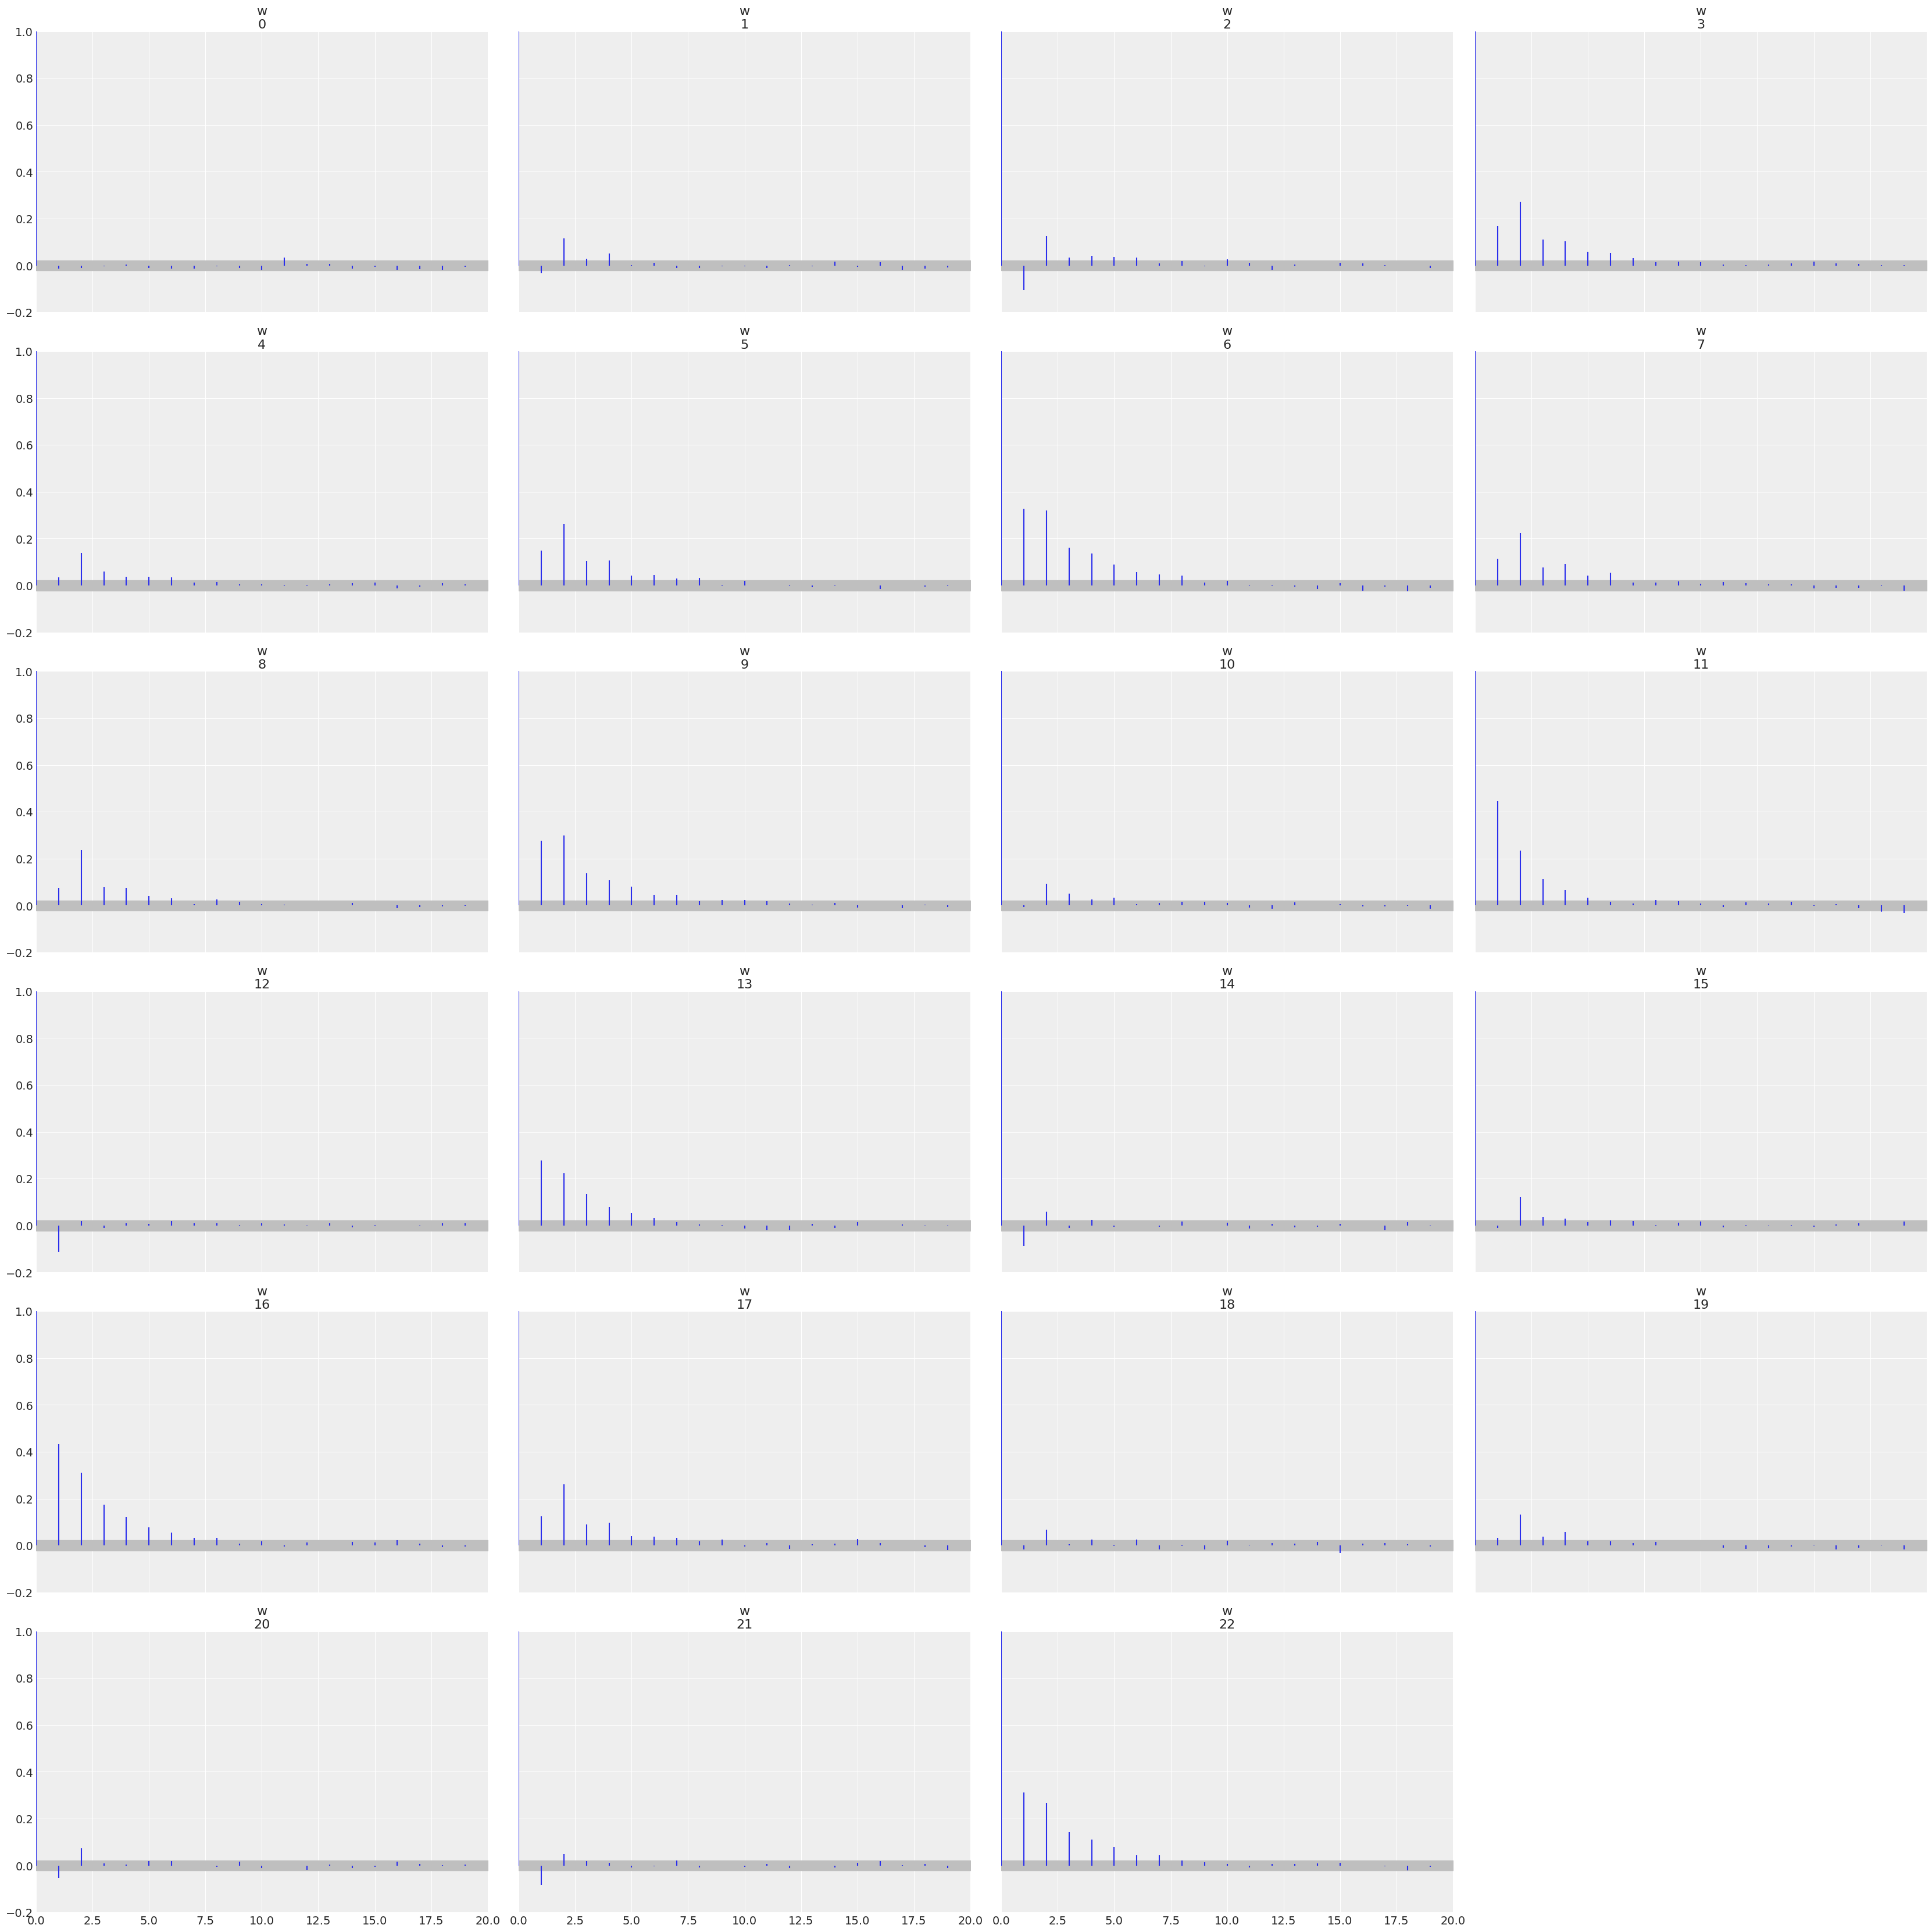

In [ ]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.926,0.015,0.897,0.955,0.000,0.000,8246.0,6311.0,1.0
w[1],-0.017,0.019,-0.051,0.020,0.000,0.000,6036.0,6031.0,1.0
w[2],-0.041,0.016,-0.072,-0.011,0.000,0.000,5748.0,5929.0,1.0
w[3],-0.046,0.021,-0.085,-0.007,0.000,0.000,2947.0,4772.0,1.0
w[4],-0.065,0.020,-0.101,-0.026,0.000,0.000,4581.0,5128.0,1.0
w[5],-0.148,0.022,-0.190,-0.106,0.000,0.000,3127.0,4891.0,1.0
w[6],-0.097,0.032,-0.155,-0.037,0.001,0.000,2345.0,4391.0,1.0
w[7],-0.038,0.021,-0.078,0.000,0.000,0.000,3420.0,5000.0,1.0
w[8],-0.142,0.020,-0.180,-0.104,0.000,0.000,3701.0,5445.0,1.0
w[9],-0.124,0.026,-0.171,-0.075,0.001,0.000,2545.0,4517.0,1.0


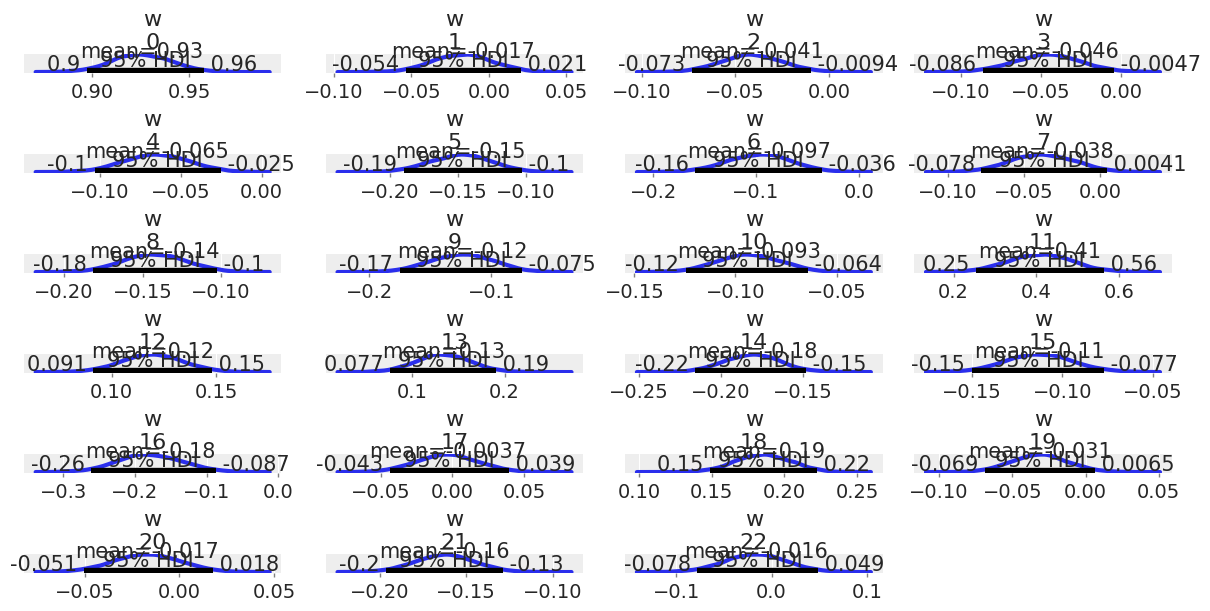

In [ ]:
az.plot_posterior(trace, hdi_prob=0.95,
                  figsize=(12,6), lw=3);

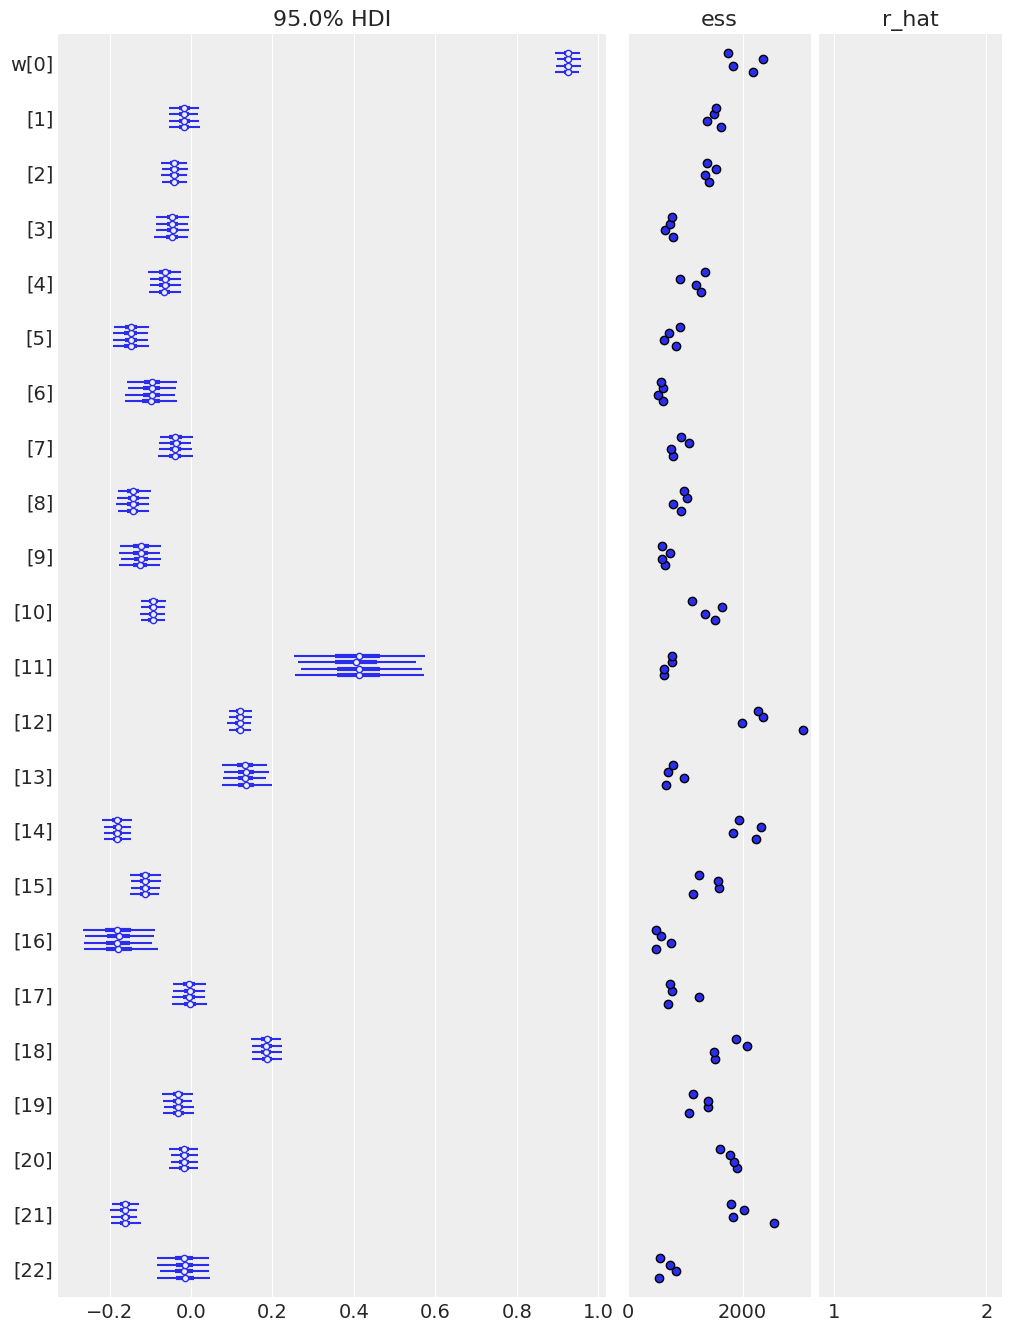

In [ ]:
az.plot_forest(trace, hdi_prob=0.95,
               r_hat=True, ess=True);

In [ ]:
# transform weights back to original scale
w_trace = np.zeros((23, draws * chains))
w_trace[0] = trace.posterior['w'][...,0].values.reshape(-1)
for i in range(1, 23):
  w_trace[0] -= x_means[i - 1] / x_scales[i - 1] * w_trace[i]

for i in range(1, 23):
  w_trace[i] = trace.posterior['w'][...,i].values.reshape(-1)
  w_trace[i] /= x_scales[i-1]

w_trace = np.stack(w_trace, axis=-1)
w_trace.shape

(8000, 23)

PREDICTION

In [ ]:
X_new = zX
X_new

array([[ 1.        , -0.47538751, -0.80093738, ..., -0.67899172,
        -1.32844535, -0.51198143],
       [ 1.        , -0.74685364, -0.02666346, ...,  2.67510903,
         0.63005001,  0.5733945 ],
       [ 1.        , -0.78846357, -0.87254419, ..., -0.18657277,
        -0.61144728, -1.23958443],
       ...,
       [ 1.        , -0.25220521, -0.15257642, ..., -0.08907126,
        -0.95159682, -0.60780855],
       [ 1.        , -0.48452543,  0.97844983, ..., -0.78404077,
        -0.13055003, -0.68009719],
       [ 1.        ,  0.56435025, -0.04696546, ...,  1.26452468,
         0.92640555,  0.73827541]])

In [ ]:
X_new.shape[0]

23562

In [ ]:
y_prob = np.zeros(X_new.shape[0])

In [ ]:
from scipy.stats import logistic
for i in range(X_new.shape[0]):
  y_prob[i] = int(logistic.cdf(w_trace.dot(X_new[i])).mean() > 0.5)

In [ ]:
y_prob

array([1., 0., 1., ..., 1., 1., 0.])

In [ ]:
t

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
print("level group --> ", lg)
print("Train fscore --> ", f1_score(t, y_prob))
print("Train accuracy_score --> ", accuracy_score(t, y_prob))
labels = np.array([0, 1])
print("Train hinge_loss --> ", hinge_loss(t, y_prob, labels = labels))
print()

level group -->  13-22
Train fscore -->  0.7701244813278009
Train accuracy_score -->  0.6708259061200238
Train hinge_loss -->  0.6215092097445039



Хуже, чем у логистической регрессии -_-



╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ